In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, ttest_rel

import rl

In this notebook, we perform simulations of the whole planned experiment. This includes the following steps:

### 1. Baseline: Initialize a group of Dual-Learning-Rate agents with

- known model parameters $\Theta = (\alpha_+, \alpha_-, \beta)$. The parameters are based on a prior study (Lefebvre et al., 2017).

- known baseline physiological markers $\Phi = (\phi_{DA}$, $\phi_{SE})$, assumed to be correlated with the learning rate parameters with known $r$.

### 2. Treatment `D`:
1. Put the agents on a diet aimed to
    1. Change their physiological marker $\phi^D_{DA}$
    2. In turn, change their learning rate $\alpha_+$ (with known effect size)

2. Take a (noisy) measurement of the physiological markers $\Phi^D$, with assumed measurement error $\epsilon_\Phi$

3. Let the agents perform a reinforcement learning task (either reversal learning, or multiple-state bandit) and estimate model parameters $\Theta_D$ with some error $\epsilon_\Theta$
    
### 3. Treatment `S`:
1. Put the agents on a diet aimed to
    1. Change their physiological marker $\phi^S_{SE}$
    2. In turn, change their learning rate $\alpha_-$ (with known effect size)

2. Take a (noisy) measurement of the physiological markers $\Phi^S$, with assumed measurement error $\epsilon_\Phi$

3. Let the agents perform a reinforcement learning task (either reversal learning, or multiple-state bandit) and estimate model parameters $\Theta_S$ with some error $\epsilon_\Theta$
    
### 4. Final analysis of interest:

1. Correlate difference in physiological markers between treatments with difference in learning rates between treatments:
    - $\hat{\alpha}^D_+ - \hat{\alpha}^S_+$ vs. $\phi^D_{DA} - \phi^S_{DA}$
    - $\hat{\alpha}^D_- - \hat{\alpha}^S_-$ vs. $\phi^D_{SE} - \phi^S_{SE}$

---

# 1. Initialize agents

First, we initialize 50 dual-learning rate agents, with known parameters $\Theta = (\alpha_+, \alpha_-, \beta)$ taken from Lefebvre et al. (2017):

In [2]:
N = 50
lefebvre_estimates = pd.read_csv("lefebvre-2017_exp1_RWpn-estimates.csv", index_col=0)

In [3]:
alpha_pos = lefebvre_estimates["alpha_pos"].values
alpha_neg = lefebvre_estimates["alpha_neg"].values
beta = lefebvre_estimates["beta"].values

Next, we generate baseline physiological markers $\Phi = (\phi_{DA}, \phi_{SE})$, so that they are correlated with the true learning parameters with a given effect size ($r$ = 0.3):

In [4]:
phi_alpha_r = 0.5
phi_da_bl = rl.simulation_utils.generate_correlated_array(
    source=alpha_pos, target_r=phi_alpha_r
)
phi_se_bl = rl.simulation_utils.generate_correlated_array(
    source=alpha_neg, target_r=phi_alpha_r
)

r = 0.50, p = 0.0002
r = 0.50, p = 0.0002


Make a plot of the learning rates and physiological parameters:

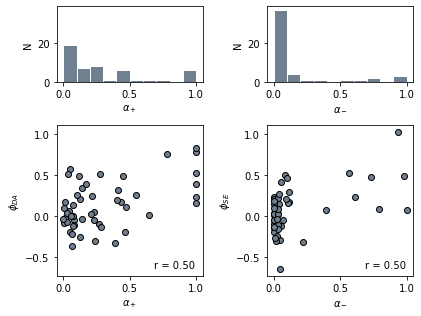

In [37]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(6, 4.5),
    sharey="row",
    sharex="col",
    gridspec_kw={"height_ratios": [1, 2]},
)

alpha_bins = np.linspace(0, 1, 11)

# Histograms of alphas
for ax, alphas, label in zip(
    axs[0, :], [alpha_pos, alpha_neg], [r"$\alpha_+$", r"$\alpha_-$"]
):
    ax.hist(alphas, bins=alpha_bins, color="slategray", edgecolor="white")
    ax.set_xlabel(label)
    ax.set_ylabel("N")

# Scatterplots alphas vs. phis
for ax, alphas, phis, xlabel, ylabel in zip(
    axs[1, :],
    [alpha_pos, alpha_neg],
    [phi_da_bl, phi_se_bl],
    [r"$\alpha_+$", r"$\alpha_-$"],
    [r"$\phi_{DA}$", r"$\phi_{SE}$"],
):
    ax.plot(alphas, phis, "o", color="slategray", markeredgecolor="k")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    r, p = pearsonr(alphas, phis)
    ax.annotate(f"r = {r:.2f}", xy=(0.95, 0.05), xycoords="axes fraction", ha="right")

# Show all x- and y-ticks, even though y-axis was shared (https://stackoverflow.com/a/49670059)
for ax in axs.flatten():
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

fig.tight_layout()

Now we can initiate the agent objects. Parameters are available in the `agent_vars` attribute.

In [17]:
agents = []
for i in range(N):
    agent_vars = rl.agent.AgentVars(
        alpha_pos=lefebvre_estimates["alpha_pos"].values[i],
        alpha_neg=lefebvre_estimates["alpha_neg"].values[i],
        beta=lefebvre_estimates["beta"].values[i],
        phi_da=phi_da_bl[i],
        phi_se=phi_se_bl[i],
    )
    agent = rl.agent.DualLearningRateAgent(
        agent_vars=agent_vars, n_options=1, n_states=4, variant="delta"
    )
    agents.append(agent)

In [18]:
agents[0].agent_vars.phi_se

0.4780908531318093

# 2. Treatment `D`

1. Put the agents on a diet aimed to
    1. Change their physiological marker $\phi^D_{DA}$
    2. In turn, change their learning rate $\alpha_+$ (with known effect size)

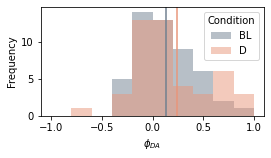

In [41]:
# Breakfast time
np.random.seed(1)
d = np.random.normal(loc=0.4 * np.std(phi_da_bl), scale=np.std(phi_da_bl), size=N)
phi_da_d = phi_da_bl + d

# Histogram of values
fig, ax = plt.subplots(figsize=(4, 2))

ax.hist(
    phi_da_bl, alpha=0.5, label="BL", bins=np.linspace(-1, 1, 11), color="slategray"
)
ax.hist(phi_da_d, alpha=0.5, label="D", bins=np.linspace(-1, 1, 11), color="darksalmon")
ax.axvline(phi_da_bl.mean(), color="slategray")
ax.axvline(phi_da_d.mean(), color="darksalmon")
ax.set_xlabel(r"$\phi_{DA}$")
ax.set_ylabel("Frequency")
ax.legend(title="Condition");

In [50]:
sd_pooled = np.sqrt(0.5 * (phi_da_d.std() ** 2 + phi_da_bl.std() ** 2))
cohens_d = (phi_da_d.mean() - phi_da_bl.mean()) / sd_pooled
t, p = ttest_rel(phi_da_bl, phi_da_d)
print(f"t = {t:.2f}, p = {p:.4f}, d = {cohens_d:.2f}")

t = -2.70, p = 0.0094, d = 0.29


In [42]:
# Calculate new learning rates from updated physiological markers
phi_alpha_r = 0.5
alpha_pos_d = rl.simulation_utils.generate_correlated_array(
    source=phi_da_d, target_r=phi_alpha_r
)

r = 0.50, p = 0.0002


In [49]:
# Update agent parameters
for i, agent in enumerate(agents):
    agent.agent_vars.phi_da_bl = agent.agent_vars.phi_da
    agent.agent_vars.phi_da = phi_da_d[i]
    agent.agent_vars.alpha_pos_bl = agent.agent_vars.alpha_pos
    agent.agent_vars.alpha_pos = alpha_pos_d[i]

2. Take a (noisy) measurement of the physiological markers $\Phi^D$, with assumed measurement error $\epsilon_\Phi$

In [29]:
epsilon_phi = 0.1
phi_hat_da_d = np.array(
    [agent.agent_vars.phi_da for agent in agents]
) + np.random.normal(scale=epsilon_phi, size=N)

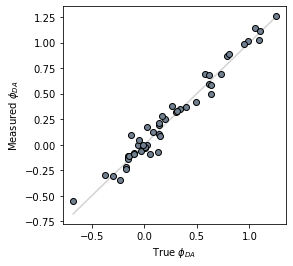

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(phi_da_d, phi_hat_da_d, "o", color="slategray", markeredgecolor="black")
ax.plot(
    [phi_da_d.min(), phi_da_d.max()],
    [phi_da_d.min(), phi_da_d.max()],
    color="lightgray",
    zorder=-1,
)
ax.set_xlabel(r"True $\phi_{DA}$")
ax.set_ylabel("Measured $\phi_{DA}$");

3. Let the agents perform a reinforcement learning task (either reversal learning, or multiple-state bandit) and estimate model parameters $\Theta_D$ with some error $\epsilon_\Theta$

# References

- Lefebvre, G., Lebreton, M., Meyniel, F., Bourgeois-Gironde, S., & Palminteri, S. (2017). Behavioural and neural characterization of optimistic reinforcement learning. Nature Human Behaviour, 1(4), 1-9.